### This notebook shows the core of the proposed framework: evaluation of ANN classifiers with latent space performance metrics

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from ml_util import *
import datasets
import generative
import cnn
from adversarial_generation import *
from evaluation_util import EvaluationUtil

### Load a dataset and classifiers

* Comment/uncomment to switch between MNIST, CelebA and LSUN

In [2]:
dataset_info = DatasetInfo.MNIST
#dataset_info = DatasetInfo.CelebA128Gender
#dataset_info = DatasetInfo.LSUN128

class_proportions = None
if dataset_info in [DatasetInfo.CelebA128Gender, DatasetInfo.LSUN128]:
    no_classes = 2
    if dataset_info == DatasetInfo.CelebA128Gender:
        ds = datasets.CelebAData(20)
        classifier_d = "celeba-128"
        class_proportions = np.array([0.583, 0.417])
    elif dataset_info == DatasetInfo.LSUN128:
        ds = datasets.LSUNData()
        classifier_d = "lsun-128"
    gm_loader = lambda label: generative.PIONEER(dataset_info, label, ds, spectral_norm_warming_no_images=25)
elif dataset_info == DatasetInfo.MNIST:
    no_classes = 10
    ds = datasets.MNISTData()
    classifier_d = "mnist"
    gm_loader = lambda label: generative.WGAN(dataset_info, label, ds)
else:
    raise RuntimeError()
if class_proportions is None:
    class_proportions = np.repeat(1 / no_classes, no_classes)
    
def load_classifier(weights_filename: str):
    c = cnn.Trainer(classifier_d, ds.get_train_loader, ds.get_test_loader)
    c.restore_params_from_disk(weights_filename)
    return c

nonrobust_classifier = load_classifier(f"new_classifiers/plain_{dataset_info.name}.bin")
robust_classifier = load_classifier(f"new_classifiers/robust_{dataset_info.name}.bin")
classifiers = [nonrobust_classifier, robust_classifier]

def advgen_experiments(adversary: Adversary, noise_eps: float, total_no_images: int):
    decay_factor = EpsDTransformer().eps_to_d(noise_eps)
    for use_generated_images in [False, True]:
        advgen = AdversarialGenerator(None, classifiers, use_generated_images, decay_factor)
        no_images = np.round(class_proportions * total_no_images)
        for i in range(no_classes):
            LogUtil.info(f"*** {classifier_d.upper()}, CLASS {i}, "
                         f"{'GENERATED' if use_generated_images else 'RECONSTRUCTED'} ***")
            LogUtil.info(f"noise_epsilon = {noise_eps:.5f}, decay_factor = {decay_factor:.5f}")
            gm = gm_loader(i)
            advgen.set_generative_model(gm)
            advgen.generate(adversary, int(no_images[i]), True, clear_stat=(i == 0))
            gm.destroy()
        LogUtil.info("*** STATISTICS ***")
        advgen.print_stats(True)

mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters


### Quick demonstration how generative models and classifiers work

* For each class, show image reconstructions (as pairs original - reconstructed) and generated images

*** MNIST, CLASS 0 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


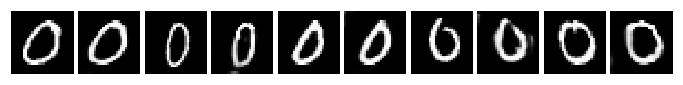

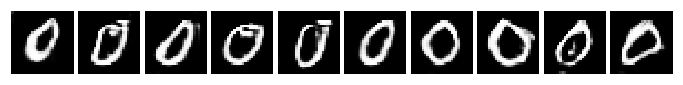

*** MNIST, CLASS 1 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


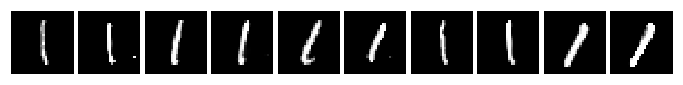

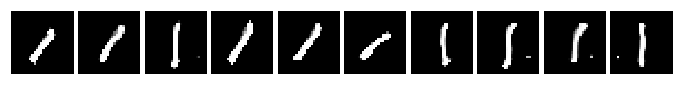

*** MNIST, CLASS 2 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


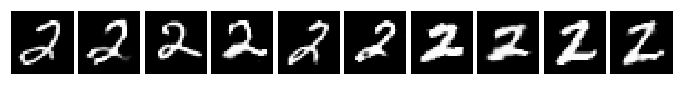

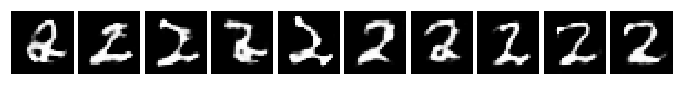

*** MNIST, CLASS 3 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


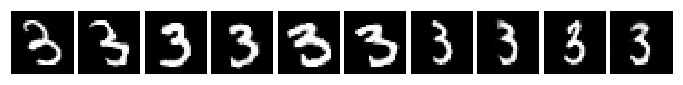

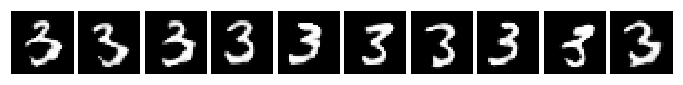

*** MNIST, CLASS 4 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


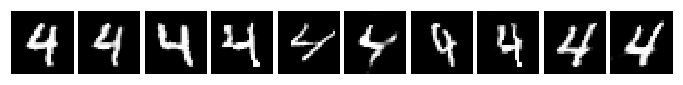

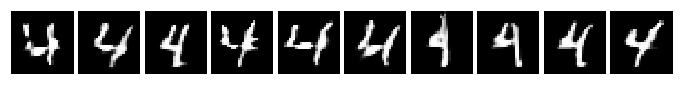

*** MNIST, CLASS 5 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


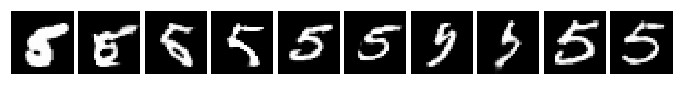

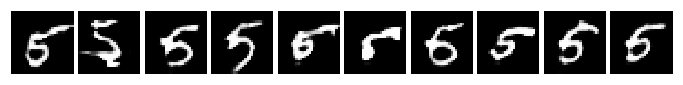

*** MNIST, CLASS 6 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


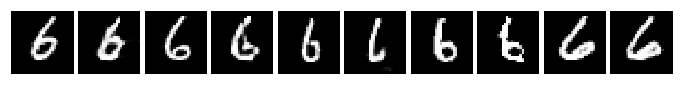

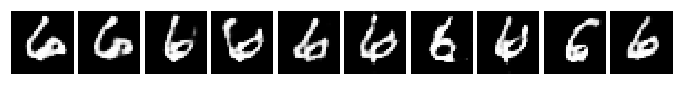

*** MNIST, CLASS 7 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


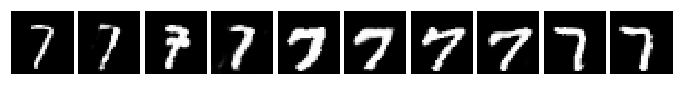

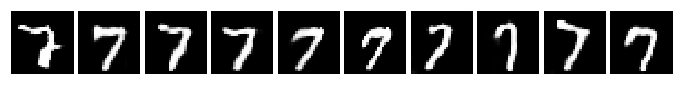

*** MNIST, CLASS 8 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


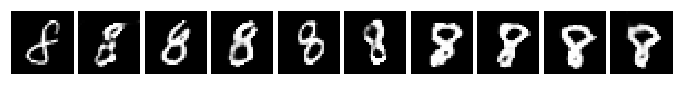

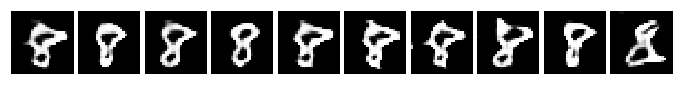

*** MNIST, CLASS 9 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


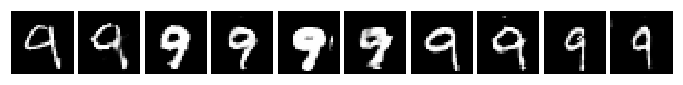

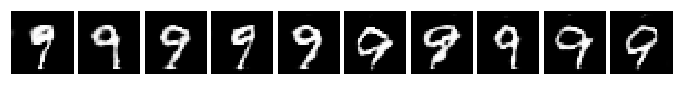

In [3]:
for i in range(no_classes):
    LogUtil.info(f"*** {classifier_d.upper()}, CLASS {i} ***")
    gm = gm_loader(i)
    EvaluationUtil.show_reconstructed_images(gm, 1, 5)
    EvaluationUtil.show_generated_images(gm, 1, 10)
    gm.destroy()

### Measure local latent noise accuracy (LLNA)

* Also show noise-based perturbations if requested
* Change the numbers of images to get more meaningful results

*** MNIST, CLASS 0 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


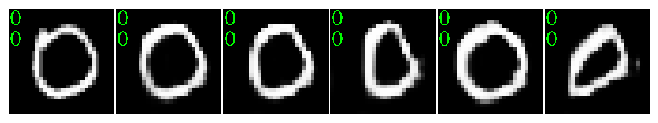

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 1 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


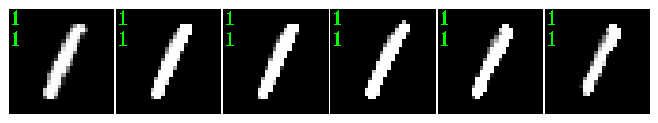

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 2 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


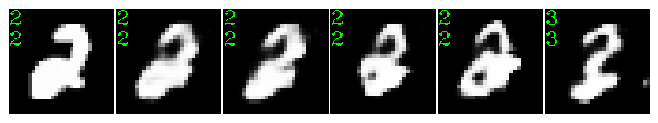

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0:   0.00%   c1:   0.00%
*** MNIST, CLASS 3 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


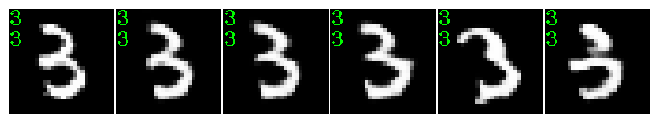

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 4 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


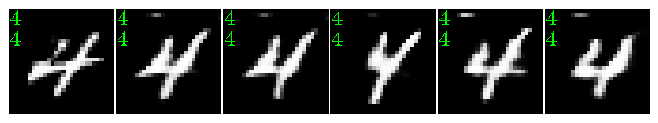

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 5 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


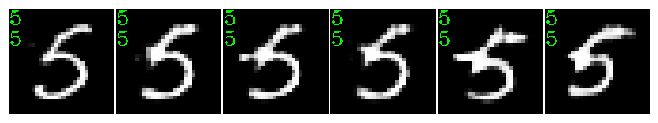

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 6 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


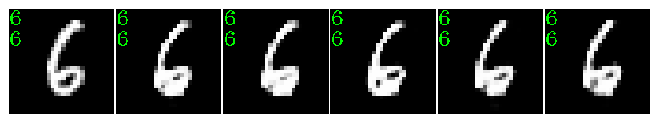

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 7 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


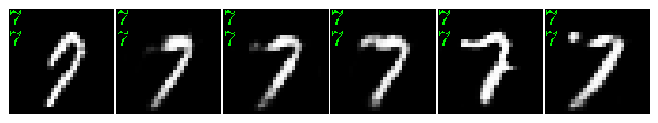

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 8 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


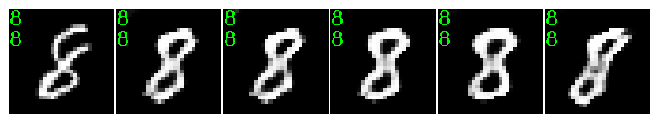

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 9 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


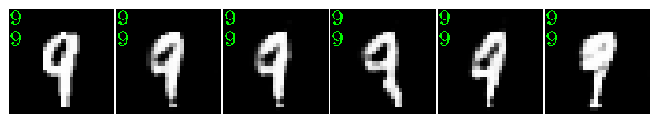

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%


In [4]:
no_images = 1
no_perturbations_per_image = 1
visualize = True
for i in range(no_classes):
    LogUtil.info(f"*** {classifier_d.upper()}, CLASS {i} ***")
    gm = gm_loader(i)
    RandomPerturbationStatistician(gm, classifiers, no_images, no_perturbations_per_image,
                                   visualize, np.linspace(0.25, 1.00, 4)).process()
    gm.destroy()

### Measure latent adversarial reconstruction/generation severity (LARS, LAGS) by searching for minimum latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of reconstructed/generated images
* Latent reconstruction/generation accuracies (LRA, LGA) are also computed
* Norms of minimum latent adversarial perturbations in the original space are also computed

*** MNIST, CLASS 0, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


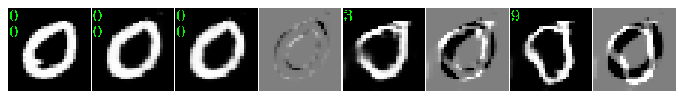

*** MNIST, CLASS 1, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


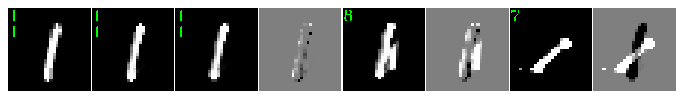

*** MNIST, CLASS 2, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


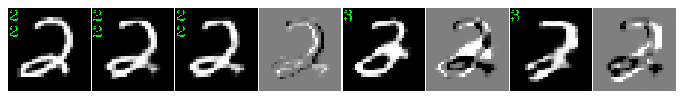

*** MNIST, CLASS 3, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


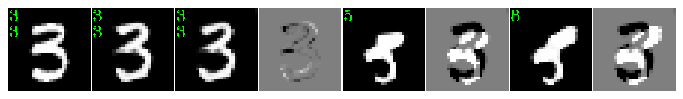

*** MNIST, CLASS 4, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


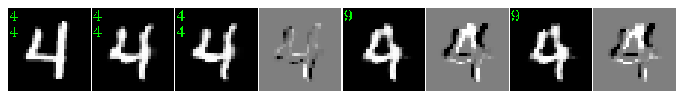

*** MNIST, CLASS 5, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


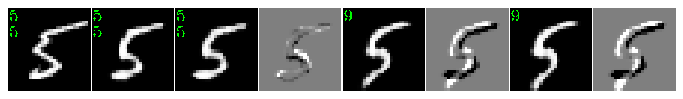

*** MNIST, CLASS 6, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


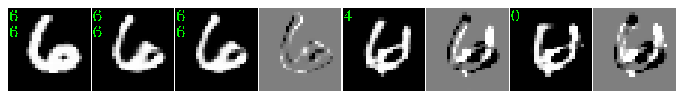

*** MNIST, CLASS 7, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


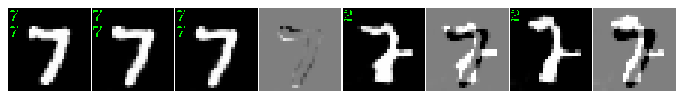

*** MNIST, CLASS 8, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


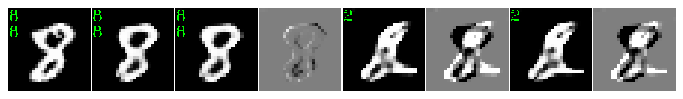

*** MNIST, CLASS 9, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


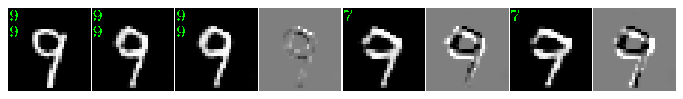

*** STATISTICS ***
Accuracy of classifier 0 on 10      original images: 100.00%
Accuracy of classifier 1 on 10      original images: 100.00%
Accuracy of classifier 0 on 10 reconstructed images: 100.00%
Accuracy of classifier 1 on 10 reconstructed images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 0.00%
Accuracy of classifier 1 on 10     perturbed images: 0.00%
For classifier 0 and 10 images,           ║Δl║ (scaled L2): mean=0.33978, std=0.12173, Q0=0.17375, Q1=0.26460, Q2=0.32961, Q3=0.41170, Q4=0.57111
For classifier 1 and 10 images,           ║Δl║ (scaled L2): mean=0.41015, std=0.20048, Q0=0.18418, Q1=0.22128, Q2=0.41141, Q3=0.53555, Q4=0.74267
For classifier 0 and 10 images, ║l + Δl║ - ║l║ (scaled L2): mean=0.07669, std=0.04695, Q0=0.02053, Q1=0.04833, Q2=0.06537, Q3=0.10136, Q4=0.18069
For classifier 1 and 10 images, ║l + Δl║ - ║l║ (scaled L2):

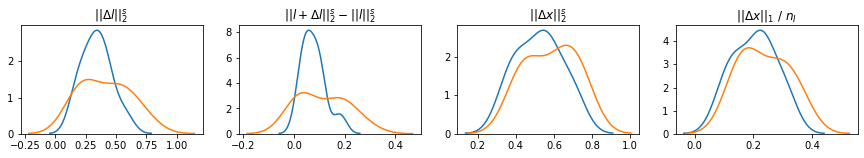

*** MNIST, CLASS 0, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


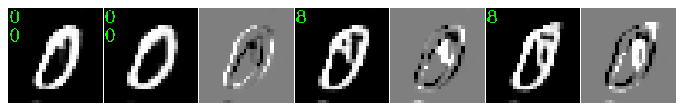

*** MNIST, CLASS 1, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


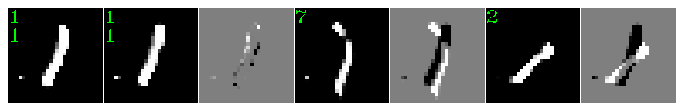

*** MNIST, CLASS 2, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


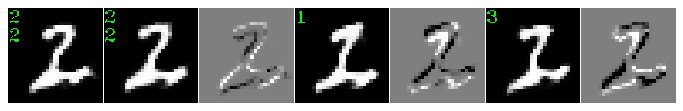

*** MNIST, CLASS 3, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


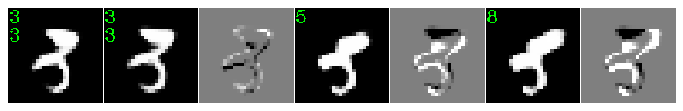

*** MNIST, CLASS 4, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


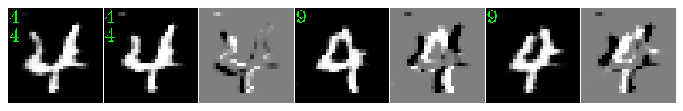

*** MNIST, CLASS 5, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


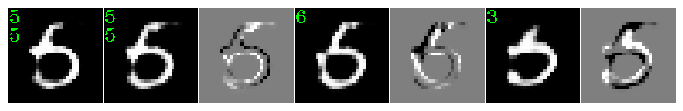

*** MNIST, CLASS 6, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


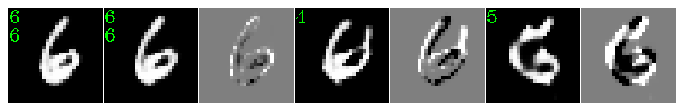

*** MNIST, CLASS 7, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


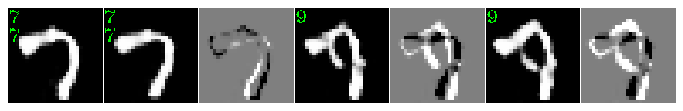

*** MNIST, CLASS 8, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


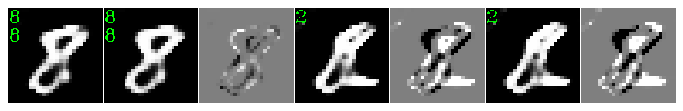

*** MNIST, CLASS 9, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


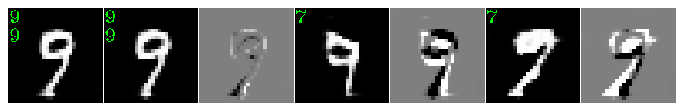

*** STATISTICS ***
Accuracy of classifier 0 on 10     generated images: 100.00%
Accuracy of classifier 1 on 10     generated images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 0.00%
Accuracy of classifier 1 on 10     perturbed images: 0.00%
For classifier 0 and 10 images,           ║Δl║ (scaled L2): mean=0.39344, std=0.17212, Q0=0.15975, Q1=0.24832, Q2=0.39041, Q3=0.49935, Q4=0.68423
For classifier 1 and 10 images,           ║Δl║ (scaled L2): mean=0.37704, std=0.17849, Q0=0.19549, Q1=0.26313, Q2=0.29969, Q3=0.48056, Q4=0.72537
For classifier 0 and 10 images, ║l + Δl║ - ║l║ (scaled L2): mean=0.13623, std=0.12066, Q0=0.02590, Q1=0.04750, Q2=0.10692, Q3=0.14157, Q4=0.37922
For classifier 1 and 10 images, ║l + Δl║ - ║l║ (scaled L2): mean=0.12326, std=0.08777, Q0=0.02506, Q1=0.07033, Q2=0.09651, Q3=0.14332, Q4=0.30717
For classifier 0 and 10 images,    

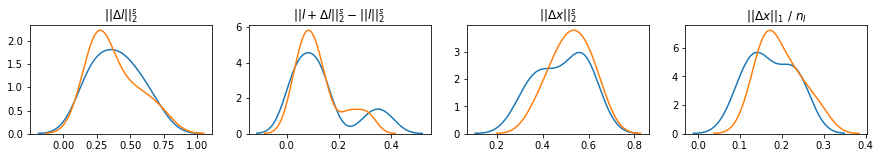

In [5]:
total_images = 10
max_rho, noise_eps = 2.5, 1.0
if dataset_info == DatasetInfo.MNIST:
    # search with restarts
    adversary = PGDAdversary(max_rho, 50, 0.05, True, 0, verbose=0, n_repeat=12, repeat_mode="min")
else:
    # search without restarts, with a smaller learning rate
    adversary = PGDAdversary(max_rho, 1250, 0.002, False, 0, verbose=0)
advgen_experiments(adversary, noise_eps, total_images)

### Measure latent adversarial reconstruction/generation accuracy (LARA, LAGA) by searching for bounded latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of reconstructed/generated images
* Latent reconstruction/generation accuracies (LRA, LGA) are also computed

*** MNIST, CLASS 0, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


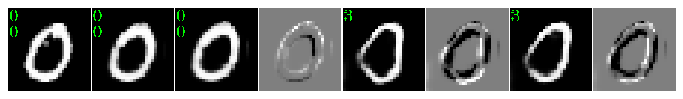

*** MNIST, CLASS 1, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


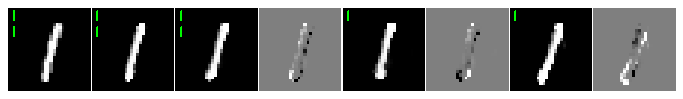

*** MNIST, CLASS 2, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


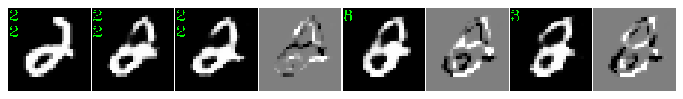

*** MNIST, CLASS 3, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


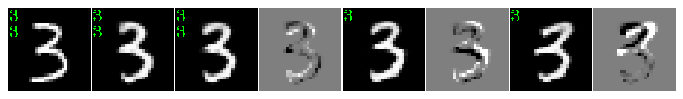

*** MNIST, CLASS 4, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


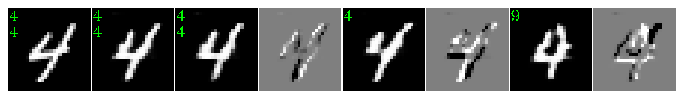

*** MNIST, CLASS 5, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


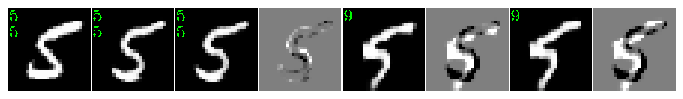

*** MNIST, CLASS 6, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


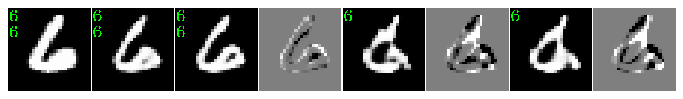

*** MNIST, CLASS 7, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


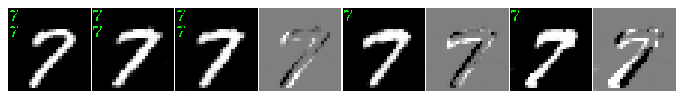

*** MNIST, CLASS 8, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


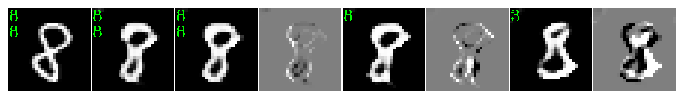

*** MNIST, CLASS 9, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


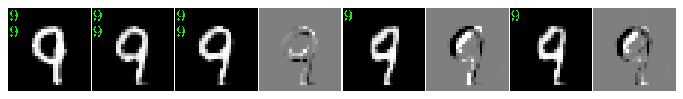

*** STATISTICS ***
Accuracy of classifier 0 on 10      original images: 100.00%
Accuracy of classifier 1 on 10      original images: 100.00%
Accuracy of classifier 0 on 10 reconstructed images: 100.00%
Accuracy of classifier 1 on 10 reconstructed images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 70.00%
Accuracy of classifier 1 on 10     perturbed images: 50.00%
For classifier 0 and 10 images,           ║Δl║ (scaled L2): mean=0.23622, std=0.04802, Q0=0.16211, Q1=0.20772, Q2=0.23000, Q3=0.27885, Q4=0.30000
For classifier 1 and 10 images,           ║Δl║ (scaled L2): mean=0.26130, std=0.04629, Q0=0.16904, Q1=0.25108, Q2=0.27031, Q3=0.29986, Q4=0.30000
For classifier 0 and 10 images, ║l + Δl║ - ║l║ (scaled L2): mean=0.05727, std=0.03769, Q0=-0.01497, Q1=0.03882, Q2=0.05261, Q3=0.08414, Q4=0.11981
For classifier 1 and 10 images, ║l + Δl║ - ║l║ (scaled L

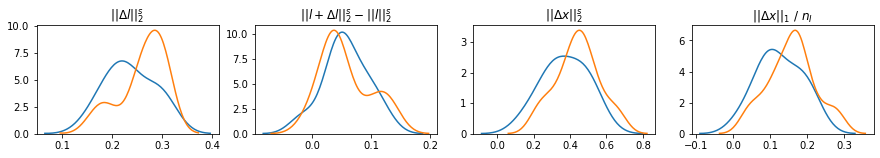

*** MNIST, CLASS 0, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


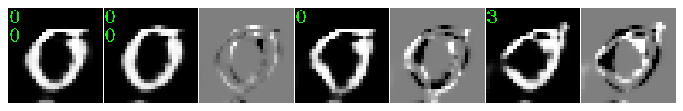

*** MNIST, CLASS 1, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


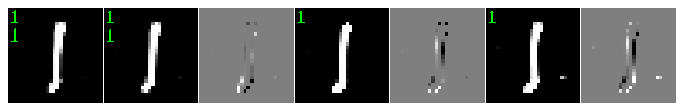

*** MNIST, CLASS 2, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


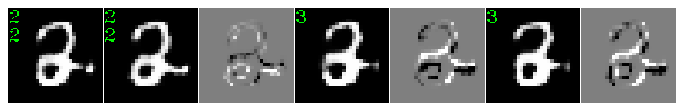

*** MNIST, CLASS 3, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


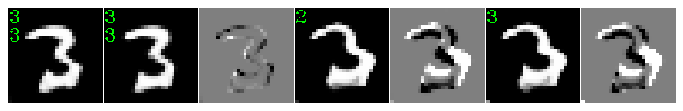

*** MNIST, CLASS 4, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


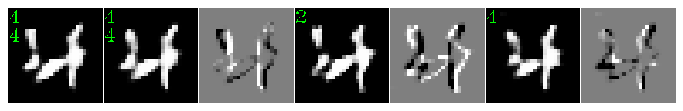

*** MNIST, CLASS 5, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


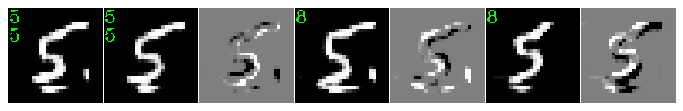

*** MNIST, CLASS 6, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


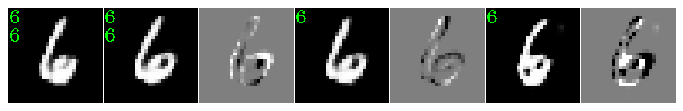

*** MNIST, CLASS 7, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


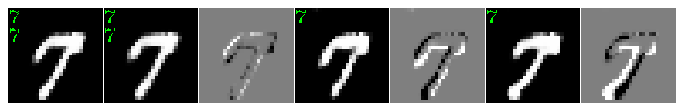

*** MNIST, CLASS 8, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


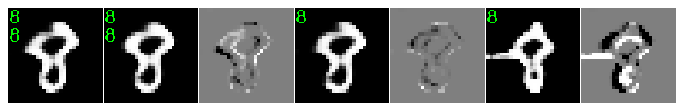

*** MNIST, CLASS 9, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


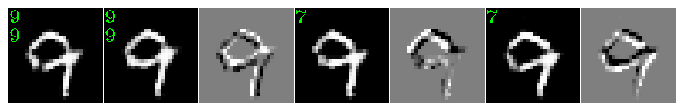

*** STATISTICS ***
Accuracy of classifier 0 on 10     generated images: 100.00%
Accuracy of classifier 1 on 10     generated images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 50.00%
Accuracy of classifier 1 on 10     perturbed images: 60.00%
For classifier 0 and 10 images,           ║Δl║ (scaled L2): mean=0.22572, std=0.05726, Q0=0.15811, Q1=0.17855, Q2=0.20459, Q3=0.28799, Q4=0.30000
For classifier 1 and 10 images,           ║Δl║ (scaled L2): mean=0.26414, std=0.05842, Q0=0.15861, Q1=0.21910, Q2=0.30000, Q3=0.30000, Q4=0.30000
For classifier 0 and 10 images, ║l + Δl║ - ║l║ (scaled L2): mean=0.06607, std=0.03428, Q0=0.00333, Q1=0.04998, Q2=0.05943, Q3=0.09632, Q4=0.10971
For classifier 1 and 10 images, ║l + Δl║ - ║l║ (scaled L2): mean=0.07145, std=0.03259, Q0=0.01906, Q1=0.04361, Q2=0.08384, Q3=0.08837, Q4=0.12927
For classifier 0 and 10 images,  

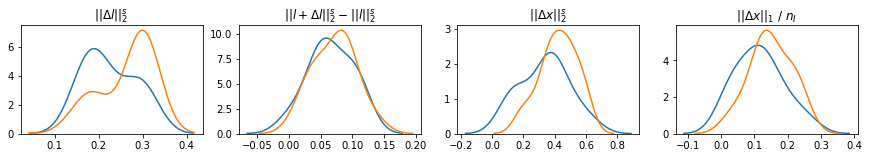

In [6]:
total_images = 10
rho, noise_eps = 0.3, 1.0
# search with restarts (a sequence of restarts will terminate if an adversarial perturbation is found)
adversary = PGDAdversary(rho, 50, 0.05, True, 0, verbose=0, n_repeat=12, repeat_mode="any")
advgen_experiments(adversary, noise_eps, total_images)